# Unbox the Cox: Why perfect predictors result in large p-values (0.9) ?

## Perfect predictors

Remember how we noted earlier that logistic regression has issue fitting perfectly separated data? In logistic regression, perfectly separated data results in infinite odds ratio ($\beta$). In Cox regression, hazard takes the place of odds so there may be a concern if we have to worry about anything here. The answer it "Yes, we do.", however as opposed to logistic regression, it is much less obvious why this happens here.

Perfect predictors in Cox regression are predictors $x$ whose ranks exactly match ranks of event times (their Spearman correlation = 1). Here is a visual example of a modified sample data where we swapped event times for subjects C and D, to make $x$ a perfect predictor of event times:

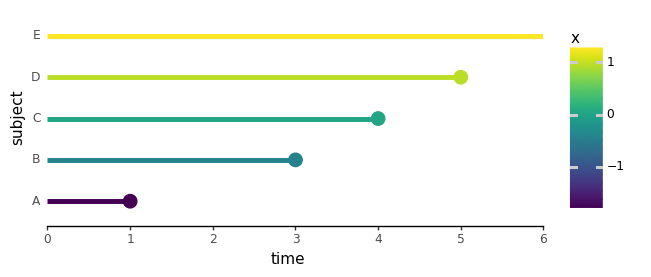

<ggplot: (322998789)>

In [3]:
import numpy as np
import pandas as pd
from cox.plots import (
    plot_subject_event_times,
    animate_subject_event_times_and_mark_at_risk,
    plot_cost_vs_beta,
)


perfect_df =  pd.DataFrame({
    'subject': ['A', 'B', 'C', 'D', 'E'],
    'time': [1, 3, 4, 5, 6],
    'event': [1, 1, 1, 1, 0],
    'x': [-1.7, -0.4, 0.0, 0.9, 1.2],
	# 'x': [0.7, 1.4, 2.0, 2.9, 3.2],
})

plot_subject_event_times(perfect_df, color_map='x')

In [4]:
animate_subject_event_times_and_mark_at_risk(
    perfect_df, color_map='x'
).save('../images/cox_likelihood_fitting_perfect.gif')

![animated_likelihood_fitting](../images/cox_likelihood_fitting_perfect.gif)

In order to understand why these "perfect predictors" can be problematic for statistical inference, we will again plot our negative log-likelihood cost vs $\beta$:

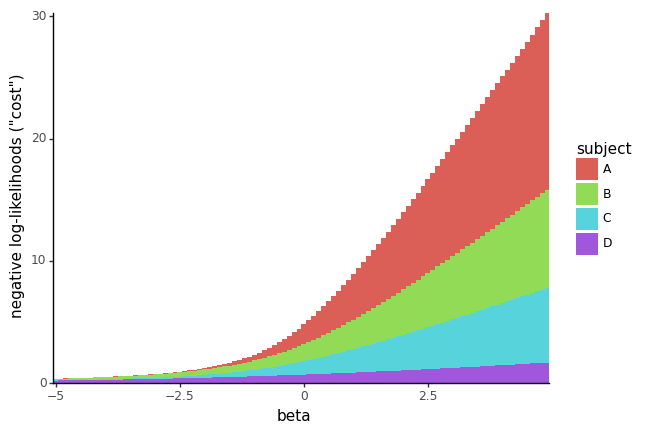

<ggplot: (322994891)>

In [5]:
def event_time_and_x_from_subject(df, subject):
    subject_with_event_df = df.query(f"subject == '{subject}' & event == 1")
    if subject_with_event_df.empty: # For censored subjects return infinite time
        return (np.inf, 0)
    return subject_with_event_df.iloc[0][['time', 'x']]

def subjects_at_risk_data(df, subject):
    time = event_time_and_x_from_subject(df, subject)[0]
    return df.query(f'time >= {time}')

def log_likelihood(df, subject, beta):
    x_subjects_at_risk = subjects_at_risk_data(df, subject)['x']
    x_subject = event_time_and_x_from_subject(df, subject)[1]
    at_risk_hazards = np.exp(beta * x_subjects_at_risk)
    return beta * x_subject - np.log(np.sum(at_risk_hazards))

def neg_log_likelihood_for_all_subjects(df, beta):
    subjects = df.query("event == 1")['subject'].tolist()
    neg_log_likelihoods = [-log_likelihood(df, subject, beta) for subject in subjects]
    return pd.DataFrame({
        'subject': subjects,
        'neg_log_likelihood': neg_log_likelihoods
    })

def neg_log_likelihood_all_subjects_sweep_betas(df, betas=np.arange(-5, 5, 0.1)):
    loglikelihoods_per_beta = []
    for beta in betas:
        beta_df = neg_log_likelihood_for_all_subjects(df, beta)
        beta_df.insert(0, 'beta', beta) # Add beta column
        loglikelihoods_per_beta.append(beta_df)
    return pd.concat(loglikelihoods_per_beta)

negloglik_sweep_betas_perfect_df = neg_log_likelihood_all_subjects_sweep_betas(
    perfect_df,
    betas=np.arange(-5, 5, 0.1)
)
plot_cost_vs_beta(negloglik_sweep_betas_perfect_df, width=0.1)

It is becoming more obvious that there is no minimum value of $\beta$, arbitrarily large negative values of $\beta$ result in arbitrarily good log-likelihood fits:

`-1.7, -0.4, 0.0, 0.9, 1.2`

If $\beta$ is large and positive, subjects A, B, have $e^{-1.7x}$, $e^{-0.4x}$

To understand what is happening let's look at the likelihood of event A, and inspect separately what is happening in the numerator and denumerator:

$$
L_A = \frac{e^{-1.7\beta}}{e^{-1.7\beta} + e^{-0.4\beta} + e^{0\beta} + e^{0.9\beta} + e^{1.2\beta}}
$$

When $\beta$ is high or a large _positive_ number, the **last** term (hazard of subject E) dominates the denumerator and becomes very large - the denumerator becomes approximately equal to $e^{1.2\beta}$. Meanwhile, the numerator becomes very small. Note that even if the numerator had a positive exponent it wouldn't matter - as long as it was less than $e^{1.2\beta}$. So hazard E, $e^{1.2\beta}$, wins and makes the entire likelihood $L_A$ very small:

$$
L_A (\mathrm{large\ positive\ \beta}) \approx \frac{e^{-1.7\beta}}{e^{1.2\beta}} = e^{(-1.7 + 1.2)\beta} = e^{-0.5\beta} \approx 0
$$

The exact same thing happens for every other individual likelihood: high $\beta$ s simulatenously _decrease_ likelihoods of all events and create increasingly poor fits for all events.

When $\beta$ is low or a large _negative_ number, the **first** term in the denumerator dominates since it has the lowest value of $x$. Since the same term is also in the numerator, the likelihood of event A, $L_A$, becomes arbitrarily close to 1, so it will have a negligible cost.

$$
L_A (\mathrm{large\ negative\ \beta}) \approx \frac{e^{-1.7\beta}}{e^{-1.7\beta}} = 1
$$

The exact same thing happens to every other individual likelihood: low $\beta$ s now simulatenously _increase_ likelihoods of all events. In other words, there are no trade-offs to having a low $\beta$. In fact, it does not even matter whether $x$ is positive or negative (it cancels out), as long as it is always the lowest so matches the numerator.

To maconsider the case when the perfect predictor isn't perfect, let's go back to the original example from the previous post where subject C experienced an event after D, despite having smaller $x$:

In [6]:
sample_df = pd.DataFrame({
    'subject': ['A', 'B', 'C', 'D', 'E'],
    'time': [1, 3, 5, 4, 6],
    'event': [1, 1, 1, 1, 0],
    'x': [-1.7, -0.4, 0.0, 0.9, 1.2],
})

For example, if event B occurred before A despite having a larger $x$, then it's likelihood will also include the hazard of A ($h_A$):

$$
L_B = \frac{h_B}{h_A + h_B + h_C + h_D + h_E}
$$

$$
L_B = \frac{e^{-0.4\beta}}{e^{-1.7\beta} + e^{-0.4\beta} + e^{0\beta} + e^{0.9\beta} + e^{1.2\beta}}
$$

When $\beta$ is large and positive it is the same thing as before, hazard E $e^{3.2\beta}$ dominates and makes this likelihood very small and close to zero. However, when $\beta$ is large and _negative_, it no longer becomes arbitrarily close to one:

$$
L_B (\mathrm{large\ negative\ \beta}) \approx \frac{e^{-0.4\beta}}{e^{-1.7\beta}} = e^{(-0.4 + 1.7)\beta} = e^{1.3\beta} \approx 0
$$

Since, the numerator and denumerator no longer cancel out, the likelihood of B is now zero in that range too. The optimal value, the maximizes this likelihood is somewhere in between as we can convince ourselves by plotting $L_B$ for various $\beta$ s:

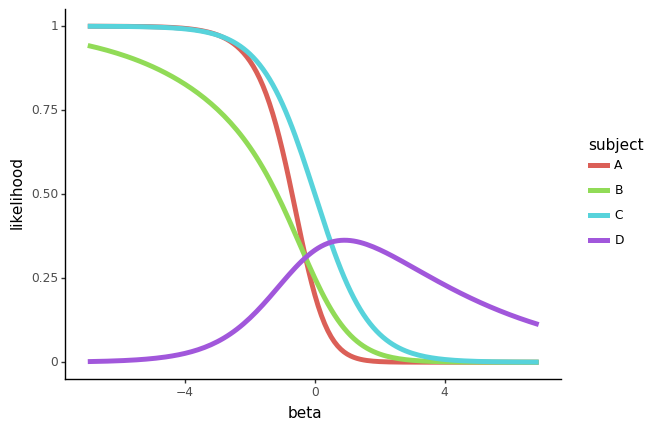

<ggplot: (323564848)>

In [7]:
import plotnine as p9

ab_swap_df =  pd.DataFrame({
    'subject': ['A', 'B', 'C', 'D', 'E'],
    'time': [3, 1, 4, 5, 6],
    'event': [1, 1, 1, 1, 0],
    'x': [-1.7, -0.4, 0.0, 0.9, 1.2],
})

def plot_likelihoods(df):
    betas = np.arange(-7, 7, 0.1)
    subjects = df.query("event == 1")['subject'].tolist()
    likelihoods_per_subject = []
    for subject in subjects:
        likelihoods = [
            np.exp(log_likelihood(df, subject, beta))
            for beta in betas
        ]
        likelihoods_per_subject.append(
            pd.DataFrame({
                'beta': betas,
                'likelihood': likelihoods,
                'subject': [subject] * len(betas),
            })        
        )
    lik_df = pd.concat(likelihoods_per_subject)
    return (
        p9.ggplot(lik_df, p9.aes('beta', 'likelihood', color='subject'))
        + p9.geom_line(size=2)
        + p9.theme_classic()
    )    



plot_likelihoods(sample_df)

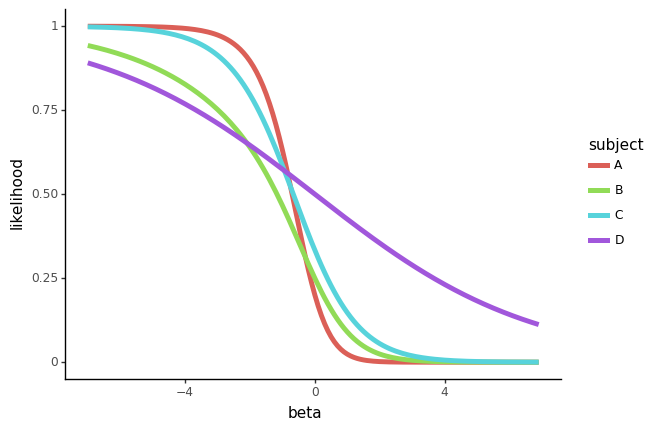

<ggplot: (323531671)>

In [8]:
plot_likelihoods(perfect_df)

$$
L_C = \frac{e^{2.0\beta}}{e^{2.0\beta} + e^{3.2\beta}}
$$

$$
\frac{}{}
$$

How do perfect predictors behave in practice? We will again use lifelines library to investigate:

In [11]:
from lifelines import CoxPHFitter

perfect_cox_model = CoxPHFitter()
perfect_cox_model.fit(perfect_df, duration_col='time', event_col='event', formula='x')
perfect_cox_model.print_summary()

/Users/igor/Library/Caches/pypoetry/virtualenvs/blog-HRL7VYfp-py3.10/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1586: ConvergenceWarning: The log-likelihood is getting suspiciously close to 0 and the delta is still large. There may be complete separation in the dataset. This may result in incorrect inference of coefficients. See https://stats.stackexchange.com/q/11109/11867 for more.

/Users/igor/Library/Caches/pypoetry/virtualenvs/blog-HRL7VYfp-py3.10/lib/python3.10/site-packages/lifelines/utils/__init__.py:1165: ConvergenceWarning: Column x has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

/Users/igor/Library/Caches/pypoetry/virtualenvs/blog-HRL7VYfp-py3.10/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to con

<lifelines.CoxPHFitter: fitted with 5 total observations, 1 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 5
number of events observed = 4
   partial log-likelihood = -0.00
         time fit was run = 2023-06-20 04:15:28 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x         -31.95       0.00     388.11          -792.62           728.73                 0.00                  inf

            cmp to     z    p   -log2(p)
covariate                               
x             0.00 -0.08 0.93       0.10
---
Concordance = 1.00
Partial AIC = 2.00
log-likelihood ratio test = 9.57 on 1 df
-log2(p) of ll-ratio test = 8.99

Similarly to logistic regression, we get convergence warnings and very large confidence intervals for our predictor (coefficient) $\beta$, resulting in a p-value of 0.93.

According to the lifeline's documentation and the StackOverflow links that are listed in these warnings, one way to deal with this type of convergence issue is to add a regularization term to the cost function. This term increases the cost for large values of coefficients and L2 regularization can be activated by setting `penalizer` argument to a value greater than zero:

In [15]:
perfect_pen_cox_model = CoxPHFitter(penalizer=0.01, l1_ratio=0)
perfect_pen_cox_model.fit(perfect_df, duration_col='time', event_col='event', formula='x')
perfect_pen_cox_model.print_summary()

<lifelines.CoxPHFitter: fitted with 5 total observations, 1 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.01
                 l1 ratio = 0
      baseline estimation = breslow
   number of observations = 5
number of events observed = 4
   partial log-likelihood = -1.01
         time fit was run = 2023-06-20 04:19:16 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x          -3.56       0.03       2.25            -7.97             0.85                 0.00                 2.35

            cmp to     z    p   -log2(p)
covariate                               
x             0.00 -1.58 0.11       3.13
---
Concordance = 1.00
Partial AIC = 4.01
log-likelihood ratio test = 7.56 on 1 df
-log2(p) of ll-ratio test = 7.39

As wel can see, while this does resolve the convergence warning, it does little to address large confidence intervals, and the corresponding p-values. Here, the p-value of a perfect predictor is still fairly large, 0.11.